In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:0


In [2]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [3]:
loss_thresh = 25000
label = "ES_stan"

x = np.linspace(0,1,500).reshape(-1,1)
y = np.linspace(0,1,500).reshape(-1,1)

X,Y = np.meshgrid(x,y)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
  
xy = np.hstack((X,Y))

# bound_pts_1 = (X == 0).reshape(-1,)
# bound_pts_2 = np.logical_and(Y == 0,X != 0).reshape(-1,)
# bound_pts_3 = np.logical_and(X == 1,Y != 0).reshape(-1,) 
# bound_pts_4 = np.logical_and(Y == 1,X != 1).reshape(-1,) 

# xy_bound_1 = xy[bound_pts_1,:]
# xy_bound_2 = xy[bound_pts_2,:]
# xy_bound_3 = xy[bound_pts_3,:]
# xy_bound_4 = xy[bound_pts_4,:]

# u_bound_1 = 1000*np.ones((np.shape(xy_bound_1)[0],1))
# u_bound_2 = 800*np.ones((np.shape(xy_bound_2)[0],1))
# u_bound_3 = 500*np.ones((np.shape(xy_bound_3)[0],1))
# u_bound_4 = np.zeros((np.shape(xy_bound_4)[0],1))

# xy_bound = np.vstack((xy_bound_1,xy_bound_2,xy_bound_3,xy_bound_4))
# u_bound = np.vstack((u_bound_1,u_bound_2,u_bound_3,u_bound_4))

# xy_test_tensor = torch.from_numpy(xy).float().to(device)

lb_xy = xy[0]
ub_xy = xy[-1]

In [4]:
fea_data = scipy.io.loadmat('./../ES_FEA.mat')

xy = np.array(fea_data['xy'])
u_true = np.array(fea_data['u'])

xy_test_tensor = torch.from_numpy(xy).float().to(device)
u_true_norm = np.linalg.norm(u_true,2)

In [5]:
def trainingdata(N_T,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    N_t = int(N_T/4)
    
    x_BC1 = np.random.uniform(size = N_t).reshape(-1,1)
    y_BC1 = np.zeros((N_t,1))
    u_BC1 = 0*np.ones((N_t,1))
    
    x_BC2 = np.ones((N_t,1))
    y_BC2 = np.random.uniform(size = N_t).reshape(-1,1) 
    u_BC2 = 1000*np.ones((N_t,1))
    
    x_BC3 = np.random.uniform(size = N_t).reshape(-1,1)
    y_BC3 = np.ones((N_t,1)) 
    u_BC3 = 0*np.ones((N_t,1))
    
    x_BC4 = np.zeros((N_t,1))
    y_BC4 = np.random.uniform(size = N_t).reshape(-1,1) 
    u_BC4 = 1000*np.ones((N_t,1))
    
    XY_corners = np.array([[0,0],[1,0],[0,1],[1,1]]).reshape(-1,2)
    U_corners = 1000*np.ones((4,1))
    
    XY_1 = np.hstack((x_BC1,y_BC1))
    XY_2 = np.hstack((x_BC2,y_BC2))
    XY_3 = np.hstack((x_BC3,y_BC3))
    XY_4 = np.hstack((x_BC4,y_BC4))
    
    xy_BC = np.vstack((XY_1,XY_2,XY_3,XY_4,XY_corners)) #choose indices from  set 'idx' (x,t)
    u_BC = np.vstack((u_BC1,u_BC2,u_BC3,u_BC4,U_corners))
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xy_coll = lb_xy + (ub_xy - lb_xy)*samples
    
    xy_coll = np.vstack((xy_coll, xy_BC)) # append training points to collocation points 

    return xy_coll, xy_BC, u_BC

In [6]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.beta = Parameter(beta_init*torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xy).float().to(device)
        lbxy = torch.from_numpy(lb_xy).float().to(device)
    
                      
        #preprocessing input 
        xy = (xy - lbxy)/(ubxy - lbxy)
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 =self.activation(z)
            a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xy,u):
                
        loss_bc = self.loss_function(self.forward(xy), u)
                
        return loss_bc
    
    def loss_PDE(self, xy_coll, f_hat):
        
        g = xy_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y = autograd.grad(u,g,torch.ones([xy_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(xy_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dx = u_x_t[:,[0]]
        
        d2u_dx2 = u_xx_yy[:,[0]]
        d2u_dy2 = u_xx_yy[:,[1]]    
        

        f = d2u_dx2 + d2u_dy2
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xy_BC,u_BC,xy_coll,f_hat):

        loss_BC = self.loss_BC(xy_BC,u_BC)
        loss_f = self.loss_PDE(xy_coll,f_hat)
        
        loss_val = loss_BC + loss_f
        
        return loss_val
     
    'callable for optimizer'  
    def closure(self):
        
        optimizer.zero_grad()
        loss = self.loss(xy_BC, u_BC, xy_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        
        u_pred = self.test(xy_test_tensor)
        #self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))) #Commented because no true values yet
        self.beta_val.append(self.beta.cpu().detach().numpy())
        
        #print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        print(self.iter,"Train Loss",self.train_loss[-1])
        
        loss.backward()
        
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self):
        u_pred = self.forward(xy_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
        
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        
        return test_mse, test_re 

In [7]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(PINN.beta.cpu().detach().numpy())
    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [8]:
def train_step(xy_BC,u_BC,xy_coll,f_hat,seed):

    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(xy_BC,u_BC,xy_coll,f_hat)
        loss.backward()
        #print(loss.cpu().detach().numpy())
        return loss

    optimizer.step(closure)

In [9]:
def train_model(max_iter,rep): 
    print(rep) 
    torch.manual_seed(rep*9)
    start_time = time.time() 
    thresh_flag = 0

    xy_coll_np_array, xy_BC_np_array, u_BC_np_array = trainingdata(N_T,N_f,rep*22)
        
    xy_coll = torch.from_numpy(xy_coll_np_array).float().to(device)
    xy_BC = torch.from_numpy(xy_BC_np_array).float().to(device)
    u_BC = torch.from_numpy(u_BC_np_array).float().to(device)
        
    f_hat = torch.zeros(xy_coll.shape[0],1).to(device)
    

    for i in range(max_iter):
        train_step(xy_BC,u_BC,xy_coll,f_hat,i)
        loss_np = PINN.loss(xy_BC,u_BC,xy_coll,f_hat).cpu().detach().numpy()
        
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1          
                thresh_flag = 1       
        data_update(loss_np)
        
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])   
        
    elapsed_time[rep] = time.time() - start_time  
    print('Training time: %.2f' % (elapsed_time[rep]))

In [10]:
max_reps = 10
max_iter = 200 #200

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))
time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

beta_init =1.0

N_T = 5000 #Total number of data points for 'y'
N_f = 10000 #Total number of collocation points 


for reps in range(max_reps):
    print(label)
    print(reps)
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    beta_val = []
    
    torch.manual_seed(reps*36)
    
    layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

    PINN = Sequentialmodel(layers,beta_init)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.5, 
                              max_iter = 20, 
                              max_eval = 30, 
                              tolerance_grad = 1e-08, 
                              tolerance_change = 1e-08, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



   
    
    nan_flag = train_model(max_iter,reps)
    
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    #elapsed_time[reps] = time.time() - start_time
    beta_full.append(beta_val)


    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full,"test_re_loss": test_re_full,"Time": elapsed_time, "beta": beta_full, "label": label,"Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

ES_stan
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 248126.16 Test MSE 74382.51381440704 Test RE 0.4771681719110999
1 Train Loss 239420.86 Test MSE 70071.56275786147 Test RE 0.4631342970559795
2 Train Loss 222422.36 Test MSE 63941.105364545525 Test RE 0.44241119874083185
3 Train Loss 197389.17 Test MSE 54548.57806499005 Test RE

96 Train Loss 38854.008 Test MSE 7081.302149641181 Test RE 0.14722874313707213
97 Train Loss 38723.47 Test MSE 7191.091334871767 Test RE 0.14836567755330116
98 Train Loss 38604.566 Test MSE 7252.106528409123 Test RE 0.14899377687670654
99 Train Loss 38521.56 Test MSE 7213.894352502449 Test RE 0.14860072583871817
100 Train Loss 38449.098 Test MSE 7175.486441097793 Test RE 0.14820461103881183
101 Train Loss 38372.465 Test MSE 7149.364109921127 Test RE 0.14793459590525632
102 Train Loss 38277.727 Test MSE 7144.11490988881 Test RE 0.14788027772651094
103 Train Loss 38171.082 Test MSE 7138.209930553907 Test RE 0.14781914975530358
104 Train Loss 38032.664 Test MSE 7108.743554652108 Test RE 0.14751373712177202
105 Train Loss 37959.082 Test MSE 7057.566068993769 Test RE 0.1469817852603267
106 Train Loss 37801.67 Test MSE 6957.342184809546 Test RE 0.1459344157657104
107 Train Loss 37691.01 Test MSE 7023.79547904397 Test RE 0.14662970824081517
108 Train Loss 37550.625 Test MSE 7043.194561703146 

0 Train Loss 247227.25 Test MSE 73905.65630611402 Test RE 0.47563617821751075
1 Train Loss 237245.06 Test MSE 69946.53929286299 Test RE 0.4627209445973497
2 Train Loss 222221.2 Test MSE 63880.97190806032 Test RE 0.44220311684867747
3 Train Loss 201602.2 Test MSE 55046.36582673254 Test RE 0.4104879075306705
4 Train Loss 177882.6 Test MSE 47360.860906988826 Test RE 0.3807551936136863
5 Train Loss 158396.11 Test MSE 41825.457322267364 Test RE 0.35781322718601494
6 Train Loss 151115.14 Test MSE 39360.92826632275 Test RE 0.34711126464627334
7 Train Loss 146365.47 Test MSE 37653.55682397235 Test RE 0.3394994266743815
8 Train Loss 135070.53 Test MSE 36392.6416790676 Test RE 0.3337665676090924
9 Train Loss 130452.766 Test MSE 33487.76806262245 Test RE 0.32016889961251355
10 Train Loss 123857.21 Test MSE 30841.601179318197 Test RE 0.30725892041942604
11 Train Loss 119034.32 Test MSE 29129.368274104243 Test RE 0.2986080936736739
12 Train Loss 116564.914 Test MSE 28209.95785568613 Test RE 0.29385

105 Train Loss 40340.695 Test MSE 6046.97485620623 Test RE 0.13605206040762904
106 Train Loss 40172.355 Test MSE 6118.638293467566 Test RE 0.1368558706974113
107 Train Loss 40059.13 Test MSE 6041.185130565204 Test RE 0.13598691272964564
108 Train Loss 39743.016 Test MSE 5821.918698782527 Test RE 0.1334962634571688
109 Train Loss 39597.74 Test MSE 5687.114200141181 Test RE 0.13194168207609575
110 Train Loss 39418.35 Test MSE 5693.24975645842 Test RE 0.13201283568474886
111 Train Loss 39281.89 Test MSE 5636.381626451793 Test RE 0.13135186306535465
112 Train Loss 39123.65 Test MSE 5631.360593769387 Test RE 0.1312933442330361
113 Train Loss 38976.754 Test MSE 5554.994106662762 Test RE 0.13040007557876754
114 Train Loss 38797.375 Test MSE 5601.441153174747 Test RE 0.13094409870691165
115 Train Loss 38480.316 Test MSE 5403.676710968704 Test RE 0.12861177172501023
116 Train Loss 38240.746 Test MSE 5374.805421104299 Test RE 0.12826773182127518
117 Train Loss 38111.09 Test MSE 5304.377544163121

0 Train Loss 244512.22 Test MSE 72882.15128727636 Test RE 0.47233119949362823
1 Train Loss 221325.4 Test MSE 63647.5268593802 Test RE 0.44139438924028956
2 Train Loss 183421.97 Test MSE 51621.73889717503 Test RE 0.39751393421305403
3 Train Loss 155774.12 Test MSE 42292.83156526332 Test RE 0.35980684671735735
4 Train Loss 139853.56 Test MSE 38793.67267162123 Test RE 0.34460096585548977
5 Train Loss 129766.02 Test MSE 37013.917059224244 Test RE 0.3366034520407117
6 Train Loss 120336.79 Test MSE 34826.66999579811 Test RE 0.32650663960867843
7 Train Loss 110877.086 Test MSE 31380.10548544978 Test RE 0.30992973249561745
8 Train Loss 104167.28 Test MSE 27729.79161784279 Test RE 0.29134619116591526
9 Train Loss 98127.24 Test MSE 25876.787043922235 Test RE 0.2814434965908649
10 Train Loss 91963.11 Test MSE 24607.555901194908 Test RE 0.27445445329265555
11 Train Loss 86931.24 Test MSE 22303.066185215546 Test RE 0.2612873164191224
12 Train Loss 82460.33 Test MSE 19408.13520018684 Test RE 0.24374

105 Train Loss 42627.52 Test MSE 6254.717702447945 Test RE 0.1383693492487201
106 Train Loss 42539.184 Test MSE 6219.336444891667 Test RE 0.13797743510829705
107 Train Loss 42470.832 Test MSE 6154.075452143205 Test RE 0.13725161082323248
108 Train Loss 42346.062 Test MSE 6175.562899787509 Test RE 0.13749101453045978
109 Train Loss 42221.793 Test MSE 6143.939173287115 Test RE 0.1371385317792626
110 Train Loss 42022.004 Test MSE 6101.121548432827 Test RE 0.1366598313587024
111 Train Loss 41899.39 Test MSE 6127.331079843907 Test RE 0.1369530521740969
112 Train Loss 41773.684 Test MSE 6117.123214999086 Test RE 0.13683892573267378
113 Train Loss 41673.23 Test MSE 6142.648603644135 Test RE 0.13712412765543786
114 Train Loss 41592.125 Test MSE 6184.691997523777 Test RE 0.1375926008478042
115 Train Loss 41510.875 Test MSE 6182.403723056422 Test RE 0.1375671445466869
116 Train Loss 41411.37 Test MSE 6200.543606535882 Test RE 0.13776881563443297
117 Train Loss 41324.035 Test MSE 6171.25206745542

0 Train Loss 254749.31 Test MSE 76171.20110621725 Test RE 0.48287135600444764
1 Train Loss 248492.52 Test MSE 74620.0081445395 Test RE 0.4779293348218222
2 Train Loss 247589.11 Test MSE 74165.99517408047 Test RE 0.47647317591597527
3 Train Loss 245614.61 Test MSE 72914.25746096278 Test RE 0.4724352241246805
4 Train Loss 244805.14 Test MSE 72555.27837353203 Test RE 0.4712708179567551
5 Train Loss 244318.83 Test MSE 72202.5610232708 Test RE 0.4701239137561013
6 Train Loss 243578.86 Test MSE 72183.93557777243 Test RE 0.47006327302552486
7 Train Loss 242234.8 Test MSE 71646.02445626666 Test RE 0.4683085537492511
8 Train Loss 240592.84 Test MSE 71054.85971542375 Test RE 0.46637250108400674
9 Train Loss 238622.7 Test MSE 70063.28619228341 Test RE 0.463106944486505
10 Train Loss 238307.89 Test MSE 69948.86256542253 Test RE 0.4627286291658612
11 Train Loss 237460.34 Test MSE 69621.18446238784 Test RE 0.4616435219497371
12 Train Loss 236884.88 Test MSE 69410.98750317963 Test RE 0.46094610910234

105 Train Loss 102203.0 Test MSE 27876.435755976916 Test RE 0.29211554197243783
106 Train Loss 102203.0 Test MSE 27876.435755976916 Test RE 0.29211554197243783
107 Train Loss 102203.0 Test MSE 27876.435755976916 Test RE 0.29211554197243783
108 Train Loss 102203.0 Test MSE 27876.435755976916 Test RE 0.29211554197243783
109 Train Loss 102203.0 Test MSE 27876.435755976916 Test RE 0.29211554197243783
110 Train Loss 102203.0 Test MSE 27876.435755976916 Test RE 0.29211554197243783
111 Train Loss 102203.0 Test MSE 27876.435755976916 Test RE 0.29211554197243783
112 Train Loss 102203.0 Test MSE 27876.435755976916 Test RE 0.29211554197243783
113 Train Loss 102203.0 Test MSE 27876.435755976916 Test RE 0.29211554197243783
114 Train Loss 102203.0 Test MSE 27876.435755976916 Test RE 0.29211554197243783
115 Train Loss 102203.0 Test MSE 27876.435755976916 Test RE 0.29211554197243783
116 Train Loss 102203.0 Test MSE 27876.435755976916 Test RE 0.29211554197243783
117 Train Loss 102203.0 Test MSE 27876.4

0 Train Loss 250867.11 Test MSE 75396.72392000633 Test RE 0.4804102663311015
1 Train Loss 245536.1 Test MSE 73482.19304521481 Test RE 0.47427157500687944
2 Train Loss 239023.8 Test MSE 70780.51939224158 Test RE 0.4654713064313761
3 Train Loss 225780.02 Test MSE 65716.09731457153 Test RE 0.44850978657067314
4 Train Loss 209993.34 Test MSE 59589.35125630392 Test RE 0.42709095159814797
5 Train Loss 189816.94 Test MSE 51753.635799112366 Test RE 0.3980214472218589
6 Train Loss 175141.12 Test MSE 46456.49607315898 Test RE 0.37710237457080686
7 Train Loss 164808.72 Test MSE 43513.51237920587 Test RE 0.3649623901633976
8 Train Loss 150669.97 Test MSE 37794.510779117874 Test RE 0.34013428152125275
9 Train Loss 140147.64 Test MSE 34602.1743200199 Test RE 0.32545259346533917
10 Train Loss 134050.25 Test MSE 32497.27977402734 Test RE 0.3153984440565077
11 Train Loss 128632.38 Test MSE 30244.731158095376 Test RE 0.3042712411889786
12 Train Loss 124200.3 Test MSE 29034.51258716871 Test RE 0.29812150

105 Train Loss 50241.754 Test MSE 9556.340044946022 Test RE 0.17103375841145635
106 Train Loss 50210.3 Test MSE 9499.034995535201 Test RE 0.17052018128158572
107 Train Loss 50158.125 Test MSE 9595.151489134409 Test RE 0.17138071869882648
108 Train Loss 50107.8 Test MSE 9710.317508391681 Test RE 0.17240615137682264
109 Train Loss 50076.84 Test MSE 9763.02402543954 Test RE 0.17287341881652288
110 Train Loss 50051.18 Test MSE 9766.569932617027 Test RE 0.1729048095744313
111 Train Loss 50020.04 Test MSE 9791.75229426877 Test RE 0.17312757705452714
112 Train Loss 49988.402 Test MSE 9702.977402605102 Test RE 0.17234097747158383
113 Train Loss 49961.492 Test MSE 9675.92020296947 Test RE 0.17210051934352624
114 Train Loss 49933.11 Test MSE 9706.858877994866 Test RE 0.17237544474640576
115 Train Loss 49909.746 Test MSE 9711.412906820608 Test RE 0.17241587547191342
116 Train Loss 49882.85 Test MSE 9683.992263904878 Test RE 0.1721722911356282
117 Train Loss 49839.16 Test MSE 9644.502431847906 Tes

0 Train Loss 252317.06 Test MSE 76264.61068152769 Test RE 0.4831673404971544
1 Train Loss 248965.75 Test MSE 74627.1953003775 Test RE 0.47795235056510227
2 Train Loss 246193.67 Test MSE 73558.37350922666 Test RE 0.4745173547514162
3 Train Loss 239651.61 Test MSE 70984.01547061729 Test RE 0.4661399480443788
4 Train Loss 227678.81 Test MSE 66682.64149662563 Test RE 0.4517960602174256
5 Train Loss 208597.16 Test MSE 58647.26297168537 Test RE 0.42370141676622475
6 Train Loss 184043.08 Test MSE 49610.80512410935 Test RE 0.3896944130173328
7 Train Loss 159783.28 Test MSE 38213.50815129841 Test RE 0.34201448255141653
8 Train Loss 148455.6 Test MSE 34804.96666357562 Test RE 0.32640488732476747
9 Train Loss 136918.5 Test MSE 31976.832147197136 Test RE 0.31286267948611995
10 Train Loss 120662.84 Test MSE 27301.031478178764 Test RE 0.28908500802412607
11 Train Loss 111102.08 Test MSE 24900.855439032457 Test RE 0.27608523125016843
12 Train Loss 98051.7 Test MSE 20998.593383556356 Test RE 0.2535310

105 Train Loss 37538.562 Test MSE 5708.550406623633 Test RE 0.13219010938702822
106 Train Loss 37402.68 Test MSE 5809.758987369398 Test RE 0.13335677984309618
107 Train Loss 37187.332 Test MSE 5718.914012537539 Test RE 0.1323100474525842
108 Train Loss 36835.906 Test MSE 5811.930681373866 Test RE 0.13338170196643948
109 Train Loss 36612.047 Test MSE 5575.834590995923 Test RE 0.1306444553717356
110 Train Loss 36349.316 Test MSE 5420.310551824828 Test RE 0.12880956889702186
111 Train Loss 36253.164 Test MSE 5274.947623897403 Test RE 0.1270706108742956
112 Train Loss 35982.473 Test MSE 5042.231221230696 Test RE 0.12423598866872382
113 Train Loss 35233.242 Test MSE 5074.416838031796 Test RE 0.12463187007911897
114 Train Loss 35053.1 Test MSE 4886.609799157408 Test RE 0.12230377796896628
115 Train Loss 34961.15 Test MSE 4763.969783779546 Test RE 0.12075928722611805
116 Train Loss 34679.863 Test MSE 4727.167243208422 Test RE 0.12029193906453849
117 Train Loss 34089.242 Test MSE 4636.74301654

0 Train Loss 255523.75 Test MSE 77515.02549379657 Test RE 0.48711217990899086
1 Train Loss 251334.94 Test MSE 75649.93103499919 Test RE 0.48121627840143305
2 Train Loss 249941.08 Test MSE 75137.43858386627 Test RE 0.4795835022018046
3 Train Loss 248673.22 Test MSE 74558.02165751961 Test RE 0.4777307867636475
4 Train Loss 247051.67 Test MSE 73875.3113109625 Test RE 0.4755385222322947
5 Train Loss 246109.0 Test MSE 73652.93141714447 Test RE 0.4748222483738155
6 Train Loss 243734.83 Test MSE 72840.129751191 Test RE 0.47219501426883814
7 Train Loss 239430.77 Test MSE 70798.10111511081 Test RE 0.4655291138580381
8 Train Loss 237377.33 Test MSE 70166.86925854528 Test RE 0.46344915167541956
9 Train Loss 234934.44 Test MSE 69708.70926444292 Test RE 0.4619336101407254
10 Train Loss 232315.78 Test MSE 68936.68611305159 Test RE 0.45936853361586416
11 Train Loss 230217.42 Test MSE 68132.75926859355 Test RE 0.4566821432924196
12 Train Loss 225997.95 Test MSE 67070.17777738042 Test RE 0.453106998947

105 Train Loss 41095.66 Test MSE 6473.934666588088 Test RE 0.14077326970956772
106 Train Loss 41095.66 Test MSE 6473.934666588088 Test RE 0.14077326970956772
107 Train Loss 41095.66 Test MSE 6473.934666588088 Test RE 0.14077326970956772
108 Train Loss 41095.66 Test MSE 6473.934666588088 Test RE 0.14077326970956772
109 Train Loss 41095.66 Test MSE 6473.934666588088 Test RE 0.14077326970956772
110 Train Loss 41095.66 Test MSE 6473.934666588088 Test RE 0.14077326970956772
111 Train Loss 41095.66 Test MSE 6473.934666588088 Test RE 0.14077326970956772
112 Train Loss 41095.66 Test MSE 6473.934666588088 Test RE 0.14077326970956772
113 Train Loss 41095.66 Test MSE 6473.934666588088 Test RE 0.14077326970956772
114 Train Loss 41095.66 Test MSE 6473.934666588088 Test RE 0.14077326970956772
115 Train Loss 41095.66 Test MSE 6473.934666588088 Test RE 0.14077326970956772
116 Train Loss 41095.66 Test MSE 6473.934666588088 Test RE 0.14077326970956772
117 Train Loss 41095.66 Test MSE 6473.934666588088 T

0 Train Loss 243645.4 Test MSE 72690.96028375956 Test RE 0.47171126185049694
1 Train Loss 222511.61 Test MSE 64357.76727581782 Test RE 0.443850308764445
2 Train Loss 177667.52 Test MSE 47836.07626757849 Test RE 0.3826606603819818
3 Train Loss 139455.23 Test MSE 37544.15259839815 Test RE 0.3390058519072587
4 Train Loss 118355.24 Test MSE 31620.5779754824 Test RE 0.3111149951613779
5 Train Loss 107106.18 Test MSE 27432.789546627926 Test RE 0.2897817479439972
6 Train Loss 96664.414 Test MSE 26086.5176645685 Test RE 0.2825817406410859
7 Train Loss 89097.48 Test MSE 24020.509949543502 Test RE 0.27116095414468694
8 Train Loss 84242.02 Test MSE 21951.322168287865 Test RE 0.2592187330858281
9 Train Loss 79596.74 Test MSE 19455.589265740517 Test RE 0.24403843791074561
10 Train Loss 75045.664 Test MSE 18214.363882994043 Test RE 0.23612558458601812
11 Train Loss 71970.055 Test MSE 17509.678817058717 Test RE 0.23151286622834588
12 Train Loss 69223.72 Test MSE 16870.063008430785 Test RE 0.227245030

105 Train Loss 44847.574 Test MSE 7765.892410270801 Test RE 0.15418130831469187
106 Train Loss 44801.76 Test MSE 7774.671423660758 Test RE 0.1542684314281228
107 Train Loss 44741.684 Test MSE 7788.280793976389 Test RE 0.1544033939314342
108 Train Loss 44648.47 Test MSE 7820.664782570092 Test RE 0.1547240687312925
109 Train Loss 44586.977 Test MSE 7716.868504280842 Test RE 0.15369388612614113
110 Train Loss 44550.81 Test MSE 7725.303657342088 Test RE 0.15377786302500032
111 Train Loss 44497.105 Test MSE 7746.983339473466 Test RE 0.1539934868791692
112 Train Loss 44428.277 Test MSE 7702.270101041325 Test RE 0.1535484419311976
113 Train Loss 44361.516 Test MSE 7751.570193767801 Test RE 0.15403906856773303
114 Train Loss 44309.406 Test MSE 7730.1687424054935 Test RE 0.1538262769558472
115 Train Loss 44257.44 Test MSE 7693.0422357801735 Test RE 0.1534564334088426
116 Train Loss 44222.96 Test MSE 7661.16054752471 Test RE 0.1531381243834154
117 Train Loss 44188.305 Test MSE 7654.863954018158 

0 Train Loss 256474.86 Test MSE 78174.45032496029 Test RE 0.4891797378380076
1 Train Loss 249826.31 Test MSE 75214.09106841905 Test RE 0.4798280666748493
2 Train Loss 244868.42 Test MSE 73032.88522192613 Test RE 0.4728193818886183
3 Train Loss 240395.28 Test MSE 70611.62919696883 Test RE 0.46491564159797266
4 Train Loss 236372.72 Test MSE 69996.89174563151 Test RE 0.46288746422192134
5 Train Loss 230718.39 Test MSE 67528.1611772851 Test RE 0.45465136966709363
6 Train Loss 224382.31 Test MSE 64870.70334598352 Test RE 0.44561555802047736
7 Train Loss 217888.55 Test MSE 62531.71328993841 Test RE 0.43750820868822554
8 Train Loss 211282.31 Test MSE 61293.7467283394 Test RE 0.4331557925739396
9 Train Loss 200381.67 Test MSE 56576.543460136745 Test RE 0.41615416660023263
10 Train Loss 192482.52 Test MSE 54603.6596999316 Test RE 0.40883391671829217
11 Train Loss 183729.52 Test MSE 50970.02451110714 Test RE 0.3949966961205502
12 Train Loss 171455.11 Test MSE 44982.22193351279 Test RE 0.37107055

105 Train Loss 41819.742 Test MSE 6255.046226132249 Test RE 0.13837298306671822
106 Train Loss 41819.742 Test MSE 6255.046226132249 Test RE 0.13837298306671822
107 Train Loss 41819.742 Test MSE 6255.046226132249 Test RE 0.13837298306671822
108 Train Loss 41819.742 Test MSE 6255.046226132249 Test RE 0.13837298306671822
109 Train Loss 41819.742 Test MSE 6255.046226132249 Test RE 0.13837298306671822
110 Train Loss 41819.742 Test MSE 6255.046226132249 Test RE 0.13837298306671822
111 Train Loss 41819.742 Test MSE 6255.046226132249 Test RE 0.13837298306671822
112 Train Loss 41819.742 Test MSE 6255.046226132249 Test RE 0.13837298306671822
113 Train Loss 41819.742 Test MSE 6255.046226132249 Test RE 0.13837298306671822
114 Train Loss 41819.742 Test MSE 6255.046226132249 Test RE 0.13837298306671822
115 Train Loss 41819.742 Test MSE 6255.046226132249 Test RE 0.13837298306671822
116 Train Loss 41819.742 Test MSE 6255.046226132249 Test RE 0.13837298306671822
117 Train Loss 41819.742 Test MSE 6255.0

0 Train Loss 248609.86 Test MSE 74450.14779971335 Test RE 0.4773850606031881
1 Train Loss 239815.34 Test MSE 71085.46492045635 Test RE 0.46647292974870286
2 Train Loss 227579.88 Test MSE 65297.15867562906 Test RE 0.4470778809411198
3 Train Loss 214233.38 Test MSE 60773.08234065968 Test RE 0.43131213155207176
4 Train Loss 197976.08 Test MSE 53251.63453449357 Test RE 0.40374068287216247
5 Train Loss 188107.66 Test MSE 50147.856775693544 Test RE 0.3917980140062186
6 Train Loss 178483.06 Test MSE 46108.42228202149 Test RE 0.3756870047734654
7 Train Loss 170352.92 Test MSE 43467.80839828237 Test RE 0.36477067251655176
8 Train Loss 153703.31 Test MSE 37492.98443444887 Test RE 0.33877476104393367
9 Train Loss 140197.97 Test MSE 33091.195182227486 Test RE 0.31826748219560497
10 Train Loss 126308.625 Test MSE 27692.943064327614 Test RE 0.2911525500677811
11 Train Loss 116053.94 Test MSE 23800.094490076666 Test RE 0.2699139820967133
12 Train Loss 103375.46 Test MSE 20516.126133188263 Test RE 0.2

105 Train Loss 32224.396 Test MSE 4964.584058577593 Test RE 0.12327569965196673
106 Train Loss 32081.008 Test MSE 4972.849284735967 Test RE 0.12337827398666279
107 Train Loss 31978.197 Test MSE 5030.600970391544 Test RE 0.12409262655401743
108 Train Loss 31711.61 Test MSE 5069.215938218051 Test RE 0.12456798450720051
109 Train Loss 31452.793 Test MSE 5098.293810797977 Test RE 0.12492474505195657
110 Train Loss 31143.15 Test MSE 5089.910127195263 Test RE 0.12482198906244091
111 Train Loss 31012.14 Test MSE 5053.800744575508 Test RE 0.12437843826527399
112 Train Loss 30852.129 Test MSE 4892.978913905164 Test RE 0.12238345622962221
113 Train Loss 30749.648 Test MSE 4933.555147635173 Test RE 0.12288985602466337
114 Train Loss 30668.756 Test MSE 5005.809904360963 Test RE 0.12378648141987797
115 Train Loss 30555.414 Test MSE 4966.439823797252 Test RE 0.12329873777343564
116 Train Loss 30444.863 Test MSE 4987.990510902762 Test RE 0.1235659610064932
117 Train Loss 30311.168 Test MSE 5013.97561

In [11]:
u_pred = PINN.test()

ValueError: cannot reshape array of size 1541 into shape (500,500)

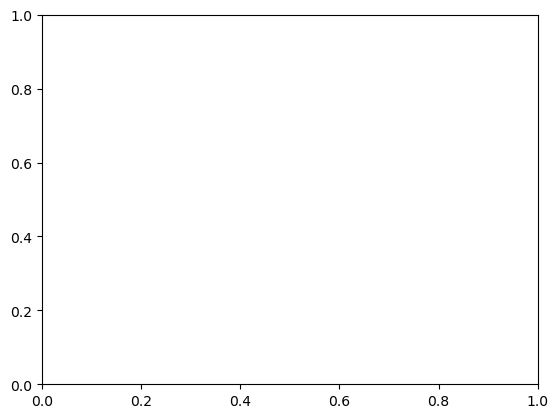

In [12]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.transpose(u_pred.reshape(500,500)),vmin = 0,vmax = 500,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)


In [15]:
a = 0
for i in range(10):
    a = a + test_re_loss[-1]
print(a/10)

0.12949936024661193


In [ ]:
a = 0
for i in range(10):
    a = a + train_loss_full[i][-1]
print(a/10)